# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [262]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [263]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [264]:
#shape of dataframes
azdias.shape, feat_info.shape

((891221, 85), (85, 4))

In [265]:
#first few rows of demographics datarame
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [266]:
#first few rows of feature summary database
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [267]:
#Before we start preprocessing, it would be a good idea to make a copy of the demographic dataframe and use that copy for the
#future operations. So that, if we ever need to look at original dataset, we will be able to do it easily

df_demo= azdias.copy()  #here 'demo' represents demographic data

---


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

#### 1) Assessing demographic dataframe for the natuarly missing values

In [268]:
# number of rows where at least one null value is present
df_demo.isnull().any(axis=1).sum()


628074

In [269]:
#columns and their corresponding count of naturally missing values
for col in df_demo.columns:
    print(col, df_demo[col].isnull().sum())

AGER_TYP 0
ALTERSKATEGORIE_GROB 0
ANREDE_KZ 0
CJT_GESAMTTYP 4854
FINANZ_MINIMALIST 0
FINANZ_SPARER 0
FINANZ_VORSORGER 0
FINANZ_ANLEGER 0
FINANZ_UNAUFFAELLIGER 0
FINANZ_HAUSBAUER 0
FINANZTYP 0
GEBURTSJAHR 0
GFK_URLAUBERTYP 4854
GREEN_AVANTGARDE 0
HEALTH_TYP 0
LP_LEBENSPHASE_FEIN 4854
LP_LEBENSPHASE_GROB 4854
LP_FAMILIE_FEIN 4854
LP_FAMILIE_GROB 4854
LP_STATUS_FEIN 4854
LP_STATUS_GROB 4854
NATIONALITAET_KZ 0
PRAEGENDE_JUGENDJAHRE 0
RETOURTYP_BK_S 4854
SEMIO_SOZ 0
SEMIO_FAM 0
SEMIO_REL 0
SEMIO_MAT 0
SEMIO_VERT 0
SEMIO_LUST 0
SEMIO_ERL 0
SEMIO_KULT 0
SEMIO_RAT 0
SEMIO_KRIT 0
SEMIO_DOM 0
SEMIO_KAEM 0
SEMIO_PFLICHT 0
SEMIO_TRADV 0
SHOPPER_TYP 0
SOHO_KZ 73499
TITEL_KZ 73499
VERS_TYP 0
ZABEOTYP 0
ALTER_HH 73499
ANZ_PERSONEN 73499
ANZ_TITEL 73499
HH_EINKOMMEN_SCORE 18348
KK_KUNDENTYP 584612
W_KEIT_KIND_HH 107602
WOHNDAUER_2008 73499
ANZ_HAUSHALTE_AKTIV 93148
ANZ_HH_TITEL 97008
GEBAEUDETYP 93148
KONSUMNAEHE 73969
MIN_GEBAEUDEJAHR 93148
OST_WEST_KZ 93148
WOHNLAGE 93148
CAMEO_DEUG_2015 98979
CAMEO

#### 2) finding columns and corresponding count where codes for missing and unknown values are present and later replacing these codes with null value


In [270]:

columns=df_demo.columns
dict_codes={}  #to save column name and its coressponding codes for missing and unknown values- for future use

for index, col in enumerate(columns):
    
    #finding the missing or unknown codes for each column and saving them in list 'codes'
    result_in_str=feat_info.iloc[index,3]
    
    codes=[]
    for value in result_in_str.strip('[]').split(','):
        try:
            codes.append(int(value))
        except ValueError:
            codes.append(value)
            
    dict_codes[col]=codes
            
    #column and their respective count for cells where missing or unknown code is present
    col_unknown_missing_val_count= df_demo[df_demo[col].isin(codes)].shape[0]
    print(col, col_unknown_missing_val_count)
            
    
    

AGER_TYP 685843
ALTERSKATEGORIE_GROB 2881
ANREDE_KZ 0
CJT_GESAMTTYP 0
FINANZ_MINIMALIST 0
FINANZ_SPARER 0
FINANZ_VORSORGER 0
FINANZ_ANLEGER 0
FINANZ_UNAUFFAELLIGER 0
FINANZ_HAUSBAUER 0
FINANZTYP 0
GEBURTSJAHR 392318
GFK_URLAUBERTYP 0
GREEN_AVANTGARDE 0
HEALTH_TYP 111196
LP_LEBENSPHASE_FEIN 92778
LP_LEBENSPHASE_GROB 89718
LP_FAMILIE_FEIN 72938
LP_FAMILIE_GROB 72938
LP_STATUS_FEIN 0
LP_STATUS_GROB 0
NATIONALITAET_KZ 108315
PRAEGENDE_JUGENDJAHRE 108164
RETOURTYP_BK_S 0
SEMIO_SOZ 0
SEMIO_FAM 0
SEMIO_REL 0
SEMIO_MAT 0
SEMIO_VERT 0
SEMIO_LUST 0
SEMIO_ERL 0
SEMIO_KULT 0
SEMIO_RAT 0
SEMIO_KRIT 0
SEMIO_DOM 0
SEMIO_KAEM 0
SEMIO_PFLICHT 0
SEMIO_TRADV 0
SHOPPER_TYP 111196
SOHO_KZ 0
TITEL_KZ 815562
VERS_TYP 111196
ZABEOTYP 0
ALTER_HH 236768
ANZ_PERSONEN 0
ANZ_TITEL 0
HH_EINKOMMEN_SCORE 0
KK_KUNDENTYP 0
W_KEIT_KIND_HH 40386
WOHNDAUER_2008 0
ANZ_HAUSHALTE_AKTIV 6463
ANZ_HH_TITEL 0
GEBAEUDETYP 0
KONSUMNAEHE 0
MIN_GEBAEUDEJAHR 0
OST_WEST_KZ 0
WOHNLAGE 0
CAMEO_DEUG_2015 373
CAMEO_DEU_2015 373
CAMEO_INTL

In [271]:
#replacing all missing and unknown values to NaN
for col in columns:
    df_demo[col]=df_demo[col].apply(lambda x: np.NaN if x in dict_codes[col] else x)
    

In [272]:
#let's see how the dataframe looks like now
df_demo.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


---

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [273]:
# missing data in each column of the demographic dataset.
for col in columns:
    print(col, df_demo[col].isnull().sum())


AGER_TYP 685843
ALTERSKATEGORIE_GROB 2881
ANREDE_KZ 0
CJT_GESAMTTYP 4854
FINANZ_MINIMALIST 0
FINANZ_SPARER 0
FINANZ_VORSORGER 0
FINANZ_ANLEGER 0
FINANZ_UNAUFFAELLIGER 0
FINANZ_HAUSBAUER 0
FINANZTYP 0
GEBURTSJAHR 392318
GFK_URLAUBERTYP 4854
GREEN_AVANTGARDE 0
HEALTH_TYP 111196
LP_LEBENSPHASE_FEIN 97632
LP_LEBENSPHASE_GROB 94572
LP_FAMILIE_FEIN 77792
LP_FAMILIE_GROB 77792
LP_STATUS_FEIN 4854
LP_STATUS_GROB 4854
NATIONALITAET_KZ 108315
PRAEGENDE_JUGENDJAHRE 108164
RETOURTYP_BK_S 4854
SEMIO_SOZ 0
SEMIO_FAM 0
SEMIO_REL 0
SEMIO_MAT 0
SEMIO_VERT 0
SEMIO_LUST 0
SEMIO_ERL 0
SEMIO_KULT 0
SEMIO_RAT 0
SEMIO_KRIT 0
SEMIO_DOM 0
SEMIO_KAEM 0
SEMIO_PFLICHT 0
SEMIO_TRADV 0
SHOPPER_TYP 111196
SOHO_KZ 73499
TITEL_KZ 889061
VERS_TYP 111196
ZABEOTYP 0
ALTER_HH 310267
ANZ_PERSONEN 73499
ANZ_TITEL 73499
HH_EINKOMMEN_SCORE 18348
KK_KUNDENTYP 584612
W_KEIT_KIND_HH 147988
WOHNDAUER_2008 73499
ANZ_HAUSHALTE_AKTIV 99611
ANZ_HH_TITEL 97008
GEBAEUDETYP 93148
KONSUMNAEHE 73969
MIN_GEBAEUDEJAHR 93148
OST_WEST_KZ 9314

In [274]:
#let's save the null values count for each column and it's ratio in two lists
missing_value_count=[]
missing_value_count_ratio=[]
for col in columns:
    missing_value_count.append(df_demo[col].isnull().sum())
    missing_value_count_ratio.append(df_demo[col].isnull().sum()/df_demo.shape[0])

In [275]:
#len(missing_value_count)

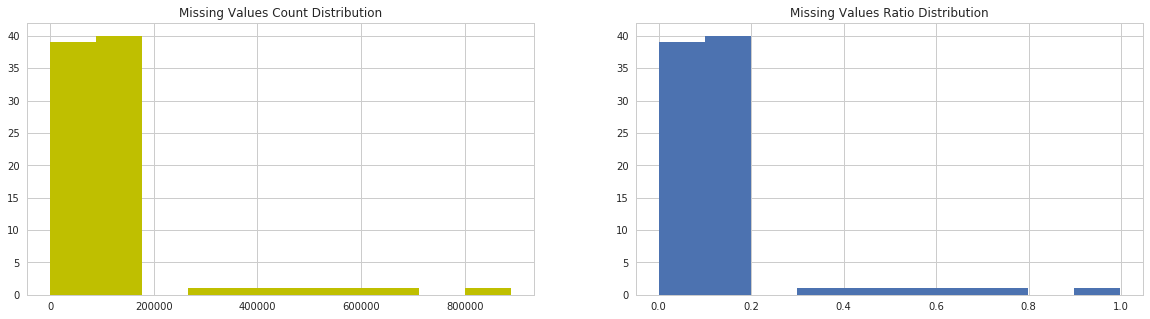

In [276]:
#plotting distribution of counts and ratios

fig,axs=plt.subplots(nrows=1,ncols=2, figsize=(20,5))
axs[0].hist(missing_value_count,color='y');
axs[0].set_title('Missing Values Count Distribution')
axs[1].hist(missing_value_count_ratio)
axs[1].set_title('Missing Values Ratio Distribution');

Text(0,0.5,'Column names')

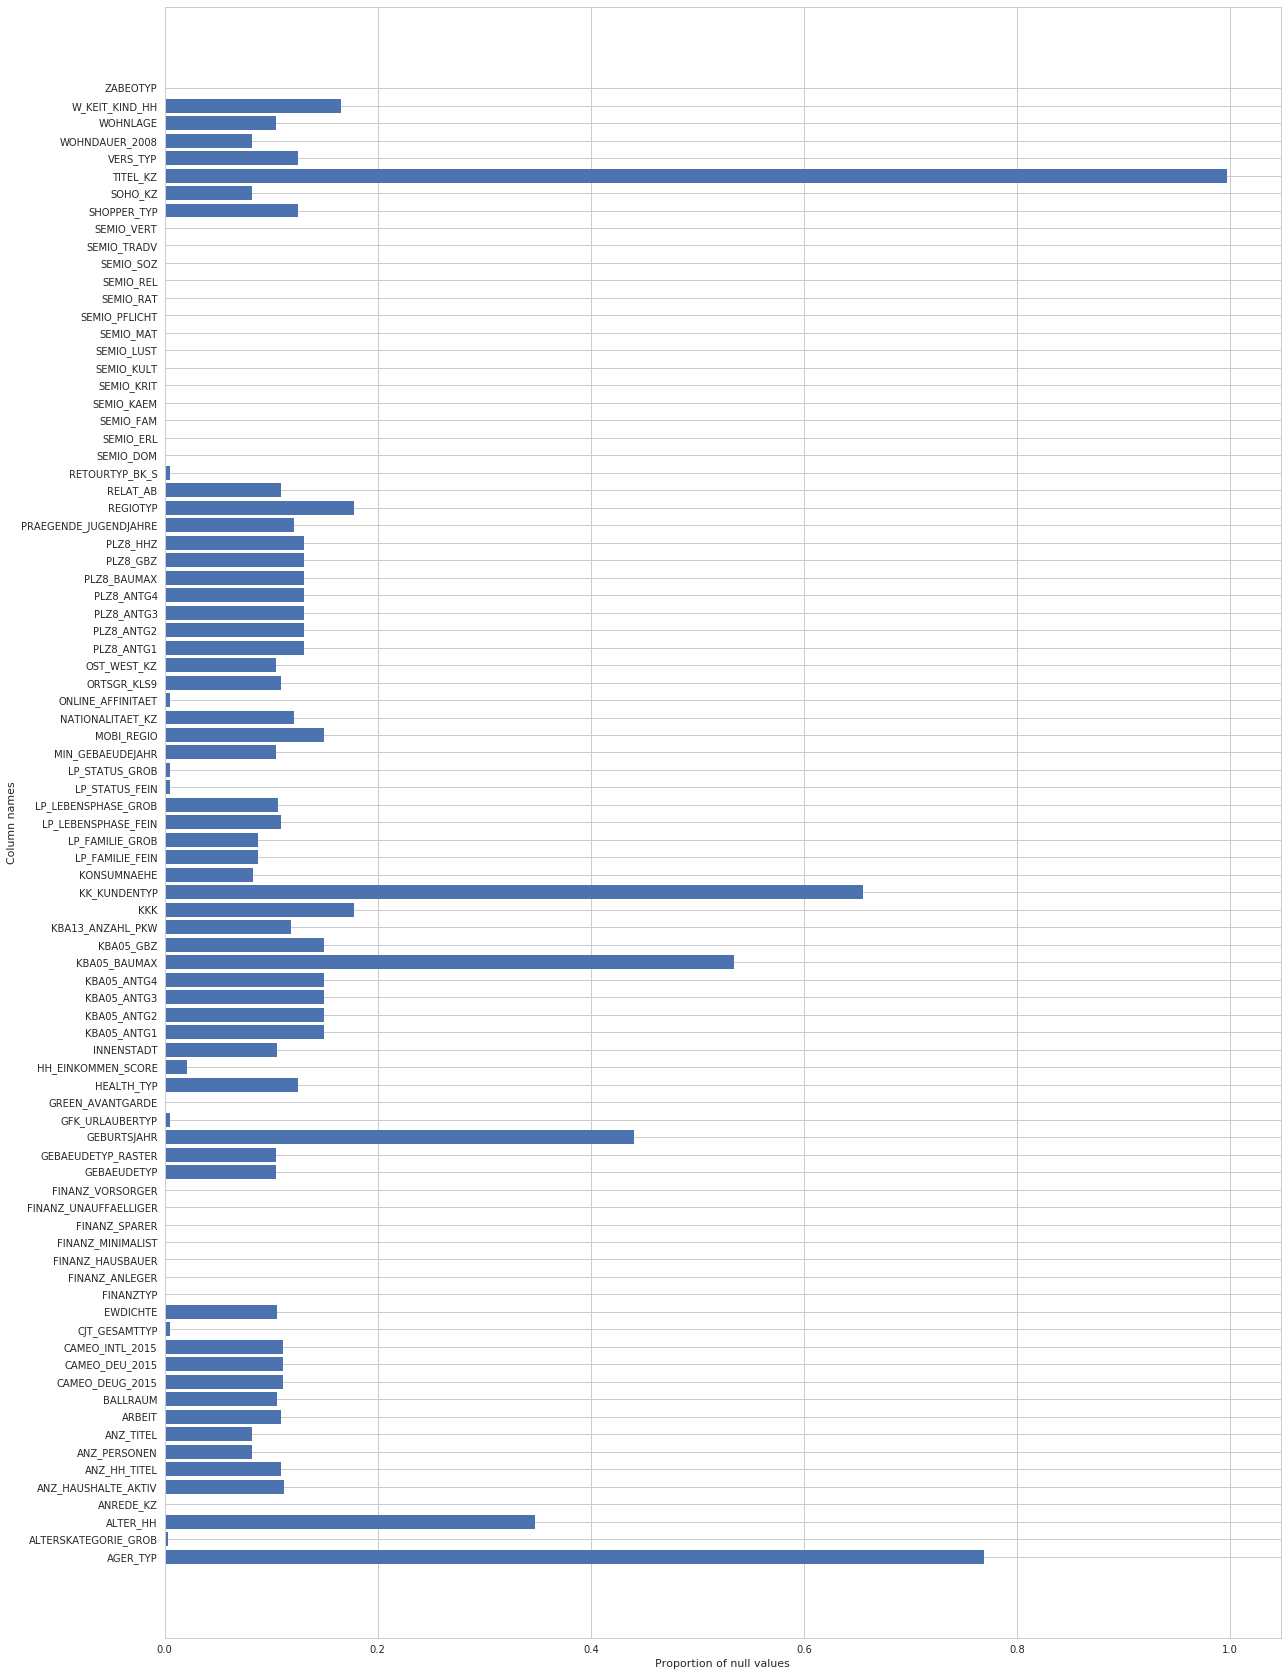

In [278]:
#let's find the null value proportion for all the coulmns
null_ratios=[]
for col in columns:
    null_ratios.append(df_demo[col].isnull().sum()/df_demo.shape[0])

plt.figure(figsize=(20,30))
plt.barh(columns, null_ratios)
plt.xlabel('Proportion of null values')
plt.ylabel('Column names')
    

In [279]:
# Remove the outlier columns from the dataset.

#finding columns where the proportion of null values present is greater than 30%
remove_col=[]
for col in columns:
    if (df_demo[col].isnull().sum()/df_demo.shape[0] > 0.3):
        remove_col.append(col)

In [280]:
#let's see the columns which got appended in list remove_col variable
print(remove_col)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [281]:
#droping these columns
df_demo.drop(columns=remove_col, inplace=True)

In [282]:
#shape of the dataframe after removing the columns
df_demo.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**Answer**

1. 79 columns in the demographic dataframe have null values proportion below 20%.
2. 6 columns in the demographic dataframe have null values proportion more than 20%.
    + Column 'AGER_TYP' has null value proportion of nearly 76%
    + Column 'GEBURTSJAHR' has null value proportion of nearly 44%
    + Column 'TITEL_KZ' has null value proportion of nearly 98%
    + Column 'ALTER_HH' has null value proportion of nearly 35%
    + Column 'KK_KUNDENTYP' has null value proportion of nearly 64%
    + Column 'KBA05_BAUMAX' has null value proportion of nearly 53%

These columns can be seen as the outliers in the histograms present above. I have removed these six columns from the dataframe.


---

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [136]:
# dividing the data into two subsets based on the number of missing values in each row.
df_null_below_20=df_demo[df_demo.isnull().sum(axis=1)<=20]
df_null_more_20=df_demo[df_demo.isnull().sum(axis=1)>20]

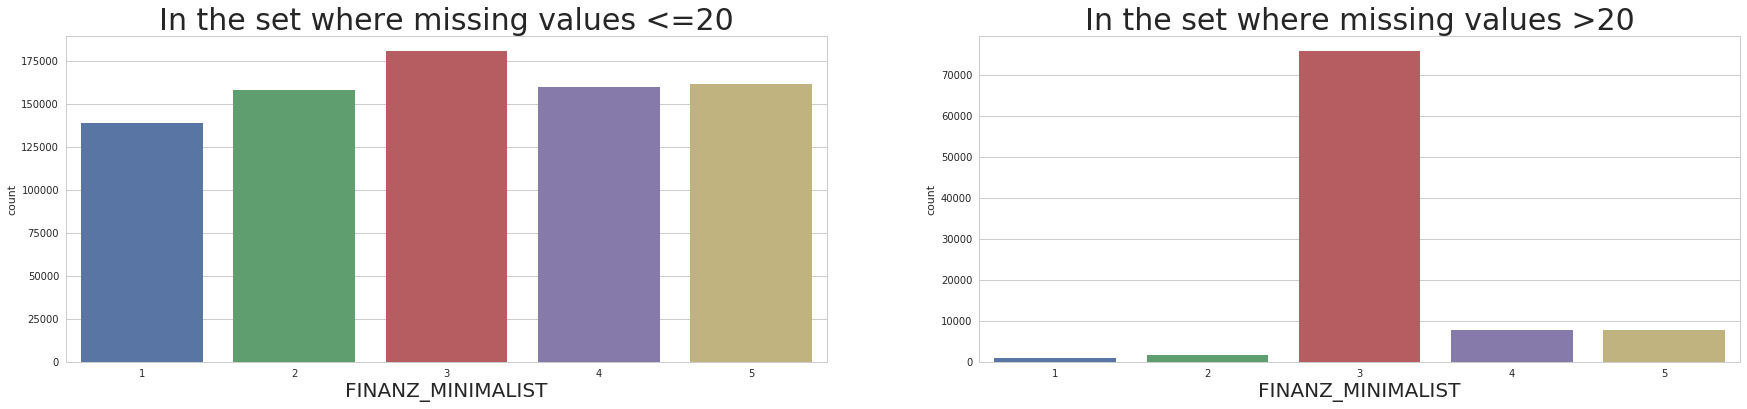

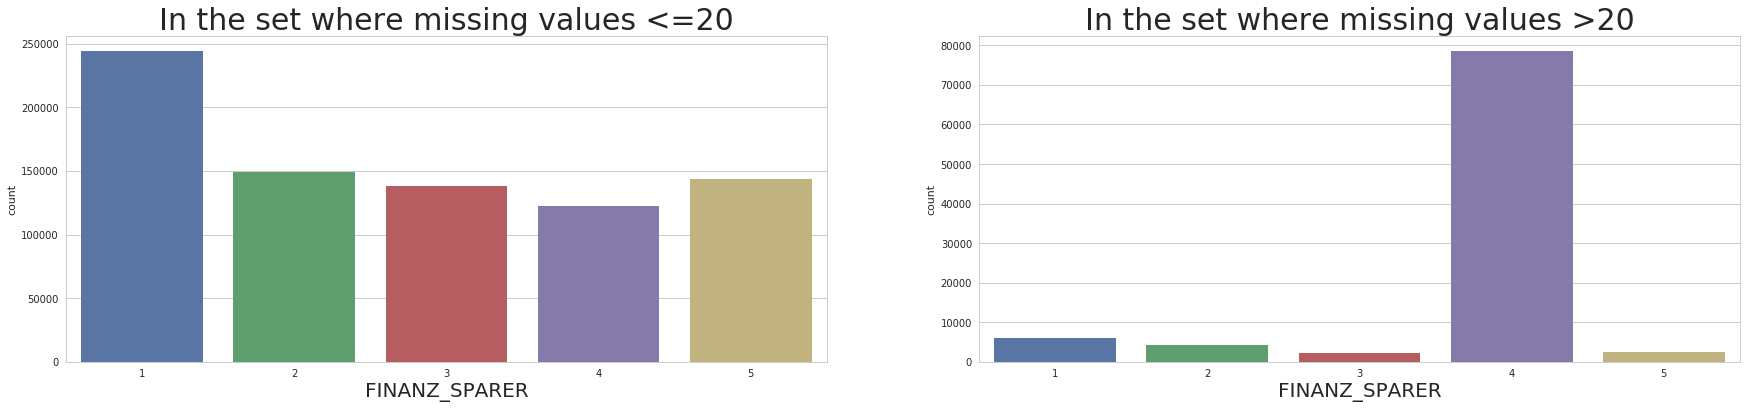

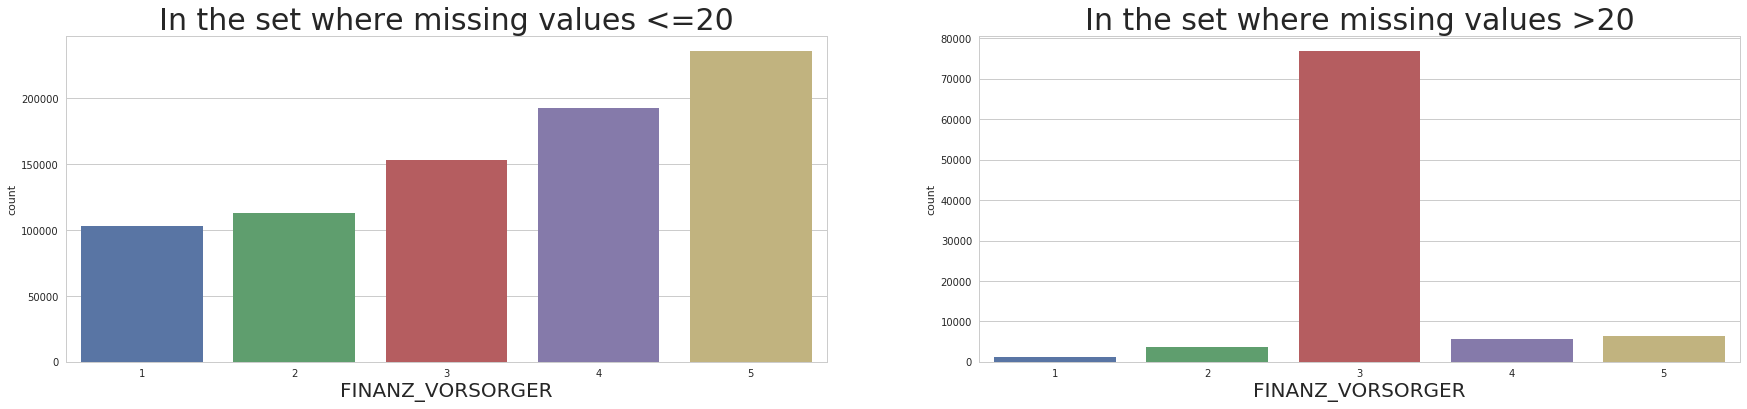

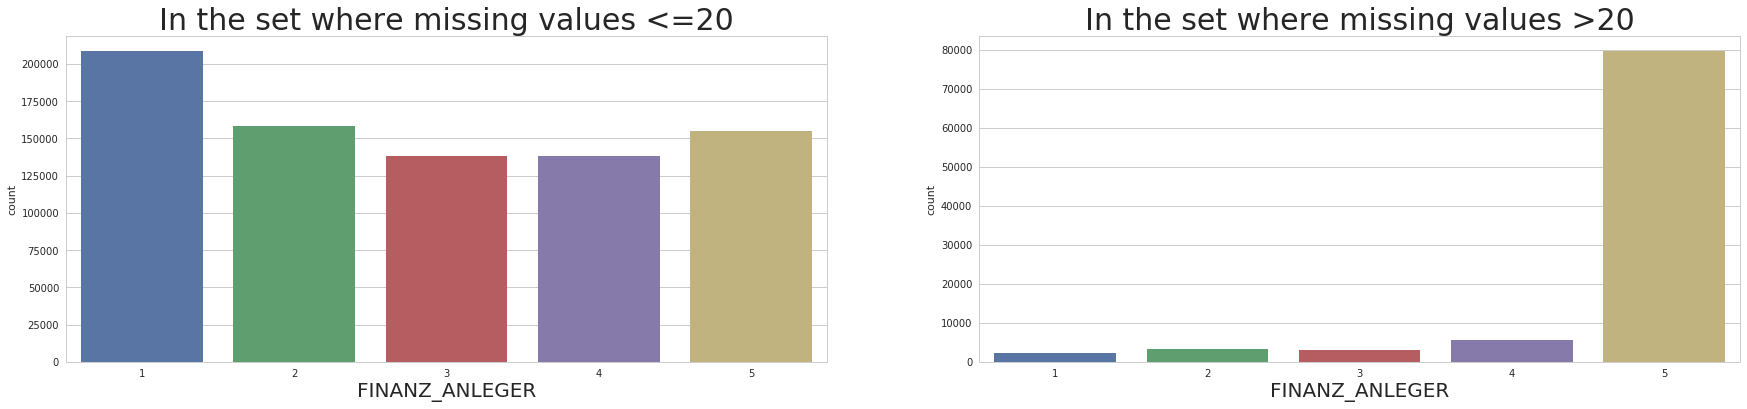

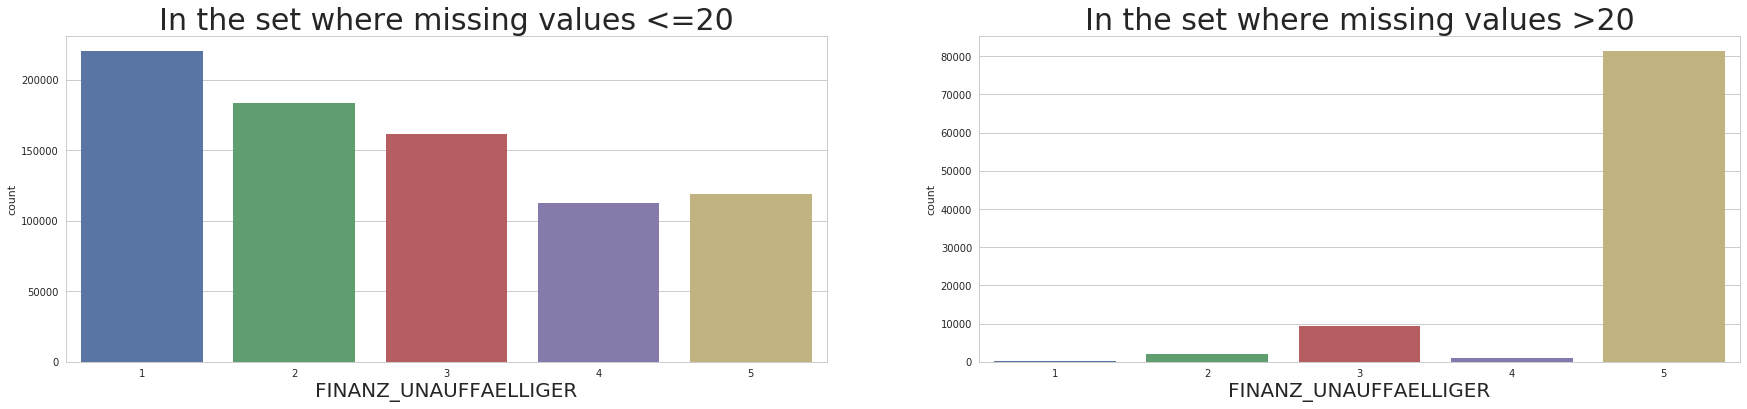

In [137]:
# Comparing the distribution of values for five columns where there are no or few missing values, between the two subsets.
def create_bar_chart(col):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,6))
    sns.countplot(df_null_below_20[col], ax=axes[0]) 
    axes[0].set_title('In the set where missing values <=20', fontsize=30)
    axes[0].set_xlabel(col, fontsize=20)
    sns.countplot(df_null_more_20[col], ax=axes[1])
    axes[1].set_title('In the set where missing values >20', fontsize=30)   
    axes[1].set_xlabel(col, fontsize=20)


#taking five columns that don't have any missing values and checking their value distributions in both the sets
for col in ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER']:
    create_bar_chart(col)


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer**: It is clearly visible that non missing features, have different distributions between the data with many missing values and the data with few or no missing values. So I will not drop the rows where null values are more(>20)

---

### Step 1.2: Select and Re-Encode Features


Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [138]:
# number of features for categorical data tyoe
feat_info[feat_info['type']=='categorical'].shape[0]

21

In [139]:
# number of features for mixed data tyoe
feat_info[feat_info['type']=='mixed'].shape[0]

7

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [140]:
# Assessing categorical variables: which are binary, which are multi-level
categorical_columns=feat_info[feat_info['type']=='categorical']['attribute']

multi_level_vari=[]
binary_level_vari=[]

for col in categorical_columns:
    
    try:
        if df_null_below_20[col].nunique()==2:
            binary_level_vari.append(col)
        else:
            multi_level_vari.append(col)
            
    except: 
        print(col+ " not available in the dataframe")   #columns which have been removed earlier


AGER_TYP not available in the dataframe
TITEL_KZ not available in the dataframe
KK_KUNDENTYP not available in the dataframe


In [141]:
#so columns in demographic dataframe that are binary categorical variable are:
binary_level_vari

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [142]:
#and, columns in demographic dataframe that are multi-level categorical variable are:
multi_level_vari

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [143]:
#binary columns and their unique values
for col in binary_level_vari:
    print(col,df_null_below_20[col].unique())
    

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
OST_WEST_KZ ['W' 'O']


In [144]:
#now we have all the binary and multi-level categorical variable with us, so let's move to encoding 
#as per the task, we need to encode a binary feature that has non-numerical value
#so we will now find that variable
for col in binary_level_vari:
    if df_null_below_20[col].dtype=='object':
        print(col)

OST_WEST_KZ


In [145]:
#encoding 'OST_WEST_KZ' feature
df_null_below_20['OST_WEST_KZ']=df_null_below_20['OST_WEST_KZ'].apply(lambda x: 0 if x=='O' else (1 if x=='W' else np.NaN))

In [146]:
#let's check the value counts again to see if the last operation got executed properly
df_null_below_20.OST_WEST_KZ.value_counts()

1    628987
0    168439
Name: OST_WEST_KZ, dtype: int64

In [147]:
#also encoding 'ANREDE_KZ' and 'VERS_TYP'. 
df_null_below_20['ANREDE_KZ']=df_null_below_20['ANREDE_KZ'].apply(lambda x: 0 if x==1 else (1 if x==2 else np.NaN))
df_null_below_20['VERS_TYP']=df_null_below_20['VERS_TYP'].apply(lambda x: 0 if x==1 else (1 if x==2 else np.NaN))

In [148]:
#multi-level categorical variable and their corresponding unique value present in them which will be encoded
for col in multi_level_vari:
    print(col,df_null_below_20[col].unique(), '\n')

CJT_GESAMTTYP [  5.   3.   2.   4.   1.   6.  nan] 

FINANZTYP [1 6 5 2 4 3] 

GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan] 

LP_FAMILIE_FEIN [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.] 

LP_FAMILIE_GROB [  3.   1.  nan   5.   2.   4.] 

LP_STATUS_FEIN [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan] 

LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan] 

NATIONALITAET_KZ [  1.   3.   2.  nan] 

SHOPPER_TYP [  3.   2.   1.   0.  nan] 

ZABEOTYP [5 3 4 1 6 2] 

GEBAEUDETYP [ 8.  1.  3.  2.  6.  4.  5.] 

CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' nan '3'] 

CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'] 



In [149]:
#now encoding all multi-level categorical variable 
df_null_below_20=pd.get_dummies(data=df_null_below_20, columns=multi_level_vari)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer**:
1. There are 21 categorical features in the feature summary dataframe, out of them 18 are present in the demographic dataframe. (As we removed few features before from the demographic dataframe)
2. Out of 18 categorical features available in the demographic dataframe, 5 are binary type variable and 13 are multi-level variable.
3. One of the binary categorical features 'OST_WEST_KZ' had non numerical values. Later, this feature was encoded with binary values 0 and 1.
4. Binary features 'ANREDE_KZ', 'VERS_TYP' was encoded with binary values 0, 1
5. All the multi-level categorical feaures have been encoded using one-hot coding technique and were added to the demographic dataframe. No feature was removed.


---

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [150]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#movement
mainstream=[1, 3, 5, 8, 10, 12, 14]
avantgrade=[2, 4, 6, 7, 9, 11, 13, 15]

#creating first new binary variable (for movement)
df_null_below_20['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=df_null_below_20['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream else (0 if x in avantgrade else x))

#creaing second variable for decade
decade_dict={1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
df_null_below_20['PRAEGENDE_JUGENDJAHRE_DECADE']=df_null_below_20['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)

#drop 'PRAEGENDE_JUGENDJAHRE' column
df_null_below_20.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

In [151]:
#investigating "CAMEO_INTL_2015" and engineer two new variables
def first_digit(x):
    try:
        return int(x)//10
    except:
        return x
    

def last_digit(x):
    try:
        return int(x)%10
    except:
        return x

    
df_null_below_20['CAMEO_INTL_2015_WEALTH']=df_null_below_20['CAMEO_INTL_2015'].apply(first_digit)
df_null_below_20['CAMEO_INTL_2015_LIFE_STAGE']=df_null_below_20['CAMEO_INTL_2015'].apply(last_digit)


#drop 'CAMEO_INTL_2015' column
df_null_below_20.drop(columns=['CAMEO_INTL_2015'], inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer:**

1. I noticed that there are two type of movements (mainstream and avantgrade), and 6 types of generations present in the 'PRAEGENDE_JUGENDJAHRE' columns. (By using Data Dictionary file)

2. Created two variables to store these movement and generation data and that are: 'PRAEGENDE_JUGENDJAHRE_MOVEMENT' and 'PRAEGENDE_JUGENDJAHRE_DECADE. Made use of 'apply' function and 'map' function to classify data.

3. Similary for feature 'CAMEO_INTL_2015' two variable are created. One is storing the first digit of the column value and another one is storing the last digit of the column  value. Columns that store the first digit represents infromation about the wealth ('CAMEO_INTL_2015_WEALTH') and the column that stores the last digit represents information about the life stages ('CAMEO_INTL_2015_LIFE_STAGE').

4. No mixed-value features have been deleted as I didn't find any problem in them.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [152]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

df_null_below_20.shape

(797426, 196)

In [153]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [290]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    
    #1) convert missing value codes into NaNs, ...
    #creating the code dictionary and replacing all missing and unknown values to NaN
    columns=df.columns
    dict_codes={}  

    for index, col in enumerate(columns):
        
        result_in_str=feat_info.iloc[index,3]
        codes=[]
        for value in result_in_str.strip('[]').split(','):
            try:
                codes.append(int(value))
            except ValueError:
                codes.append(value)
                
        dict_codes[col]=codes
        
    for col in columns:
        df[col]=df[col].apply(lambda x: np.NaN if x in dict_codes[col] else x)

        
    
    # 2) remove selected columns and rows, ...
    #remove columns i.e. rows having > 30% of missing values
    df.drop(columns=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], inplace=True)
    
    #create two groups based on the null values present in the rows
    df_less_null_values=df[df.isnull().sum(axis=1)<=20]
    df_more_null_values=df[df.isnull().sum(axis=1)>20]

    
    # 3)select, re-encode, and engineer column values.
    #encoding binary features
    df_less_null_values['OST_WEST_KZ']=df_less_null_values['OST_WEST_KZ'].apply(lambda x: 0 if x=='O' else (1 if x=='W' else np.NaN))
    df_less_null_values['ANREDE_KZ']=df_less_null_values['ANREDE_KZ'].apply(lambda x: 0 if x==1 else (1 if x==2 else np.NaN))
    df_less_null_values['VERS_TYP']=df_less_null_values['VERS_TYP'].apply(lambda x: 0 if x==1 else (1 if x==2 else np.NaN))
    
    #encoding multi-level categorical features
    df_less_null_values=pd.get_dummies(data=df_less_null_values, columns=multi_level_vari)
    
    #handling mixed type features
    
    #1) handling feature 'PRAEGENDE_JUGENDJAHRE'
    mainstream=[1, 3, 5, 8, 10, 12, 14]
    avantgrade=[2, 4, 6, 7, 9, 11, 13, 15]
    df_less_null_values['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=df_less_null_values['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream else (0 if x in avantgrade else x))
    decade_dict={1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df_less_null_values['PRAEGENDE_JUGENDJAHRE_DECADE']=df_less_null_values['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    #drop 'PRAEGENDE_JUGENDJAHRE' column
    df_less_null_values.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)
    
    #2)handling 'CAMEO_INTL_2015'
    def first_digit(x):
        try:
            return int(x)//10
        except:
            return x

    def last_digit(x):
        try:
            return int(x)%10
        except:
            return x

    df_less_null_values['CAMEO_INTL_2015_WEALTH']=df_less_null_values['CAMEO_INTL_2015'].apply(first_digit)
    df_less_null_values['CAMEO_INTL_2015_LIFE_STAGE']=df_less_null_values['CAMEO_INTL_2015'].apply(last_digit)

    #drop 'CAMEO_INTL_2015' column
    df_less_null_values.drop(columns=['CAMEO_INTL_2015'], inplace=True)
    
    #return the cleaned dataframe.
    return df_less_null_values, df_more_null_values
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [155]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#columns and corresponding total number of null values 
df_null_below_20.isnull().sum()

ALTERSKATEGORIE_GROB               2784
ANREDE_KZ                             0
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
GREEN_AVANTGARDE                      0
HEALTH_TYP                        36417
LP_LEBENSPHASE_FEIN               49651
LP_LEBENSPHASE_GROB               46830
RETOURTYP_BK_S                     4634
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0
SEMIO_ERL                             0
SEMIO_KULT                            0
SEMIO_RAT                             0
SEMIO_KRIT                            0
SEMIO_DOM                             0
SEMIO_KAEM                            0


In [207]:
#imputing data now. Creating imputer
impute= Imputer(strategy='most_frequent')
imputed_data=impute.fit_transform(df_null_below_20)

In [208]:
#converting imputed data to dataframe
df_imputed=pd.DataFrame(imputed_data)
df_imputed.columns=df_null_below_20.columns
df_imputed.index= df_null_below_20.index

In [209]:
#let's see how dataframe looks like
df_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,5.0,1.0
2,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,4.0
3,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,2.0
4,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,3.0
5,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,4.0


In [210]:
# Apply feature scaling to the general population demographics data.
scaler= StandardScaler()
feature_scaled=scaler.fit_transform(df_imputed)

#converting feature_scaled in a dataframe
df_scaled=pd.DataFrame(feature_scaled)
df_scaled.columns= df_imputed.columns
df_scaled.index=df_imputed.index

In [211]:
df_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,-1.766334,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.010368,...,-0.150091,-0.162592,-0.189578,-0.179852,-0.192844,-0.089743,0.530567,1.098531,1.175734,-1.249157
2,0.200589,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.010368,...,-0.150091,-0.162592,-0.189578,-0.179852,-0.192844,-0.089743,-1.884775,1.098531,-0.869674,0.766845
3,1.184051,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.311674,...,-0.150091,-0.162592,-0.189578,-0.179852,-0.192844,-0.089743,0.530567,-0.267356,-1.551476,-0.577156
4,0.200589,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.010368,...,-0.150091,-0.162592,-0.189578,-0.179852,-0.192844,-0.089743,0.530567,-0.267356,0.493932,0.094845
5,-1.766334,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.010368,...,-0.150091,-0.162592,-0.189578,-0.179852,-0.192844,-0.089743,0.530567,-1.633243,1.175734,0.766845


### Discussion 2.1: Apply Feature Scaling

I replaced all the missing values with the most frequent values  in columns using the Imputer method. Later, I scaled all the feature using the StandardScaler method.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [161]:
# Apply PCA to the data.
pca=PCA()
pca_below30= pca.fit_transform(df_scaled)

In [162]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

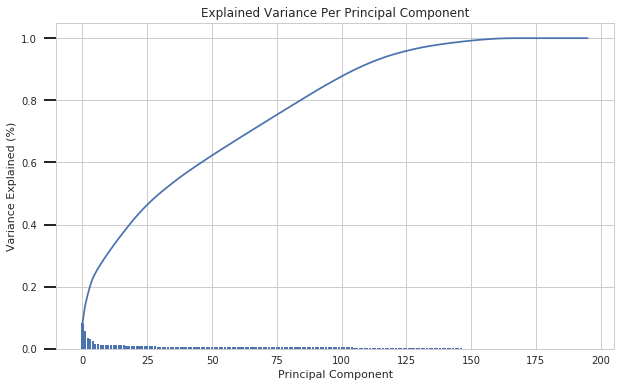

In [163]:
scree_plot(pca)

In [164]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca100=PCA(n_components=100)
pca100_below30=pca100.fit_transform(df_scaled)

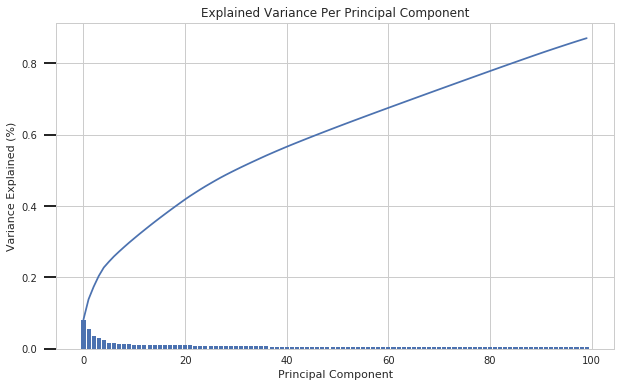

In [165]:
scree_plot(pca100)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

There are around 200 principal componets in the first chart. I am retaining 100 components. These 100 components will given me nearly 85% of total variance (It can be seen by the second chart).

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [166]:
def PCA_weights(pca,n):
    weights_df=pd.DataFrame(pca.components_,columns=list(df_scaled.columns)).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df

In [167]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PCA_weights(pca100,0)


LP_STATUS_GROB_1.0                0.189645
HH_EINKOMMEN_SCORE                0.180054
CAMEO_INTL_2015_WEALTH            0.178418
PLZ8_ANTG3                        0.178242
PLZ8_ANTG4                        0.172803
PLZ8_BAUMAX                       0.169635
ORTSGR_KLS9                       0.152856
EWDICHTE                          0.151041
FINANZ_HAUSBAUER                  0.146830
KBA05_ANTG4                       0.126500
LP_STATUS_FEIN_1.0                0.125616
PLZ8_ANTG2                        0.122502
KBA05_ANTG3                       0.113831
ANZ_HAUSHALTE_AKTIV               0.113527
ARBEIT                            0.111035
CAMEO_DEUG_2015_9                 0.110298
LP_STATUS_FEIN_2.0                0.109176
FINANZTYP_1                       0.105335
RELAT_AB                          0.105111
FINANZ_SPARER                     0.103846
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.100843
LP_FAMILIE_GROB_1.0               0.098394
LP_FAMILIE_FEIN_1.0               0.098394
CAMEO_DEUG_

In [168]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PCA_weights(pca100,1)

ALTERSKATEGORIE_GROB            0.236439
FINANZ_VORSORGER                0.222327
ZABEOTYP_3                      0.199487
SEMIO_ERL                       0.180912
SEMIO_LUST                      0.165016
RETOURTYP_BK_S                  0.154953
W_KEIT_KIND_HH                  0.123082
CJT_GESAMTTYP_2.0               0.110642
FINANZ_MINIMALIST               0.098668
FINANZTYP_5                     0.098312
FINANZTYP_2                     0.095726
LP_STATUS_FEIN_1.0              0.089008
FINANZ_HAUSBAUER                0.077466
SHOPPER_TYP_3.0                 0.075645
CJT_GESAMTTYP_1.0               0.071641
SEMIO_KRIT                      0.071546
NATIONALITAET_KZ_1.0            0.071425
FINANZTYP_6                     0.068608
LP_FAMILIE_GROB_1.0             0.060497
LP_FAMILIE_FEIN_1.0             0.060497
GFK_URLAUBERTYP_4.0             0.058238
EWDICHTE                        0.056321
WOHNDAUER_2008                  0.055750
ORTSGR_KLS9                     0.055341
PLZ8_ANTG3      

In [169]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCA_weights(pca100,2)

SEMIO_VERT                        0.313387
SEMIO_FAM                         0.254433
SEMIO_SOZ                         0.253602
SEMIO_KULT                        0.246048
FINANZTYP_5                       0.138048
FINANZ_MINIMALIST                 0.129736
ZABEOTYP_1                        0.121300
SHOPPER_TYP_0.0                   0.119934
SEMIO_REL                         0.110359
GREEN_AVANTGARDE                  0.092869
SEMIO_MAT                         0.087530
ORTSGR_KLS9                       0.077982
EWDICHTE                          0.077155
RETOURTYP_BK_S                    0.072348
LP_STATUS_GROB_5.0                0.067841
LP_STATUS_FEIN_10.0               0.067841
PLZ8_BAUMAX                       0.058793
PLZ8_ANTG4                        0.056898
PLZ8_ANTG3                        0.056466
SHOPPER_TYP_1.0                   0.051104
LP_STATUS_FEIN_3.0                0.047406
ZABEOTYP_6                        0.045728
W_KEIT_KIND_HH                    0.045647
FINANZ_VORS

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

1) from the first principal component, following features can be predicted:
- from positive weights:

    * LP_STATUS_GROB_1.0 (Social Status: low-income earners)                
    * HH_EINKOMMEN_SCORE (Estimated household net income)          
    

- from negative weights:
    * FINANZ_MINIMALIST (Financial typology: low financial interest)            
    * MOBI_REGIO (Movement patterns)          
    
    
**We can notice that first component has strong relationship with social status, estimated household income, financial typology and movement patterns**


2) from the second principal component, following features can be predicted:
- from positive weights:
    * ALTERSKATEGORIE_GROB (Estimated age)
    * FINANZ_VORSORGER (Financial typology: be prepared)      


- from negative weights:
    * FINANZ_SPARER (Financial typology: money-saver)                  
    * PRAEGENDE_JUGENDJAHRE_DECADE (movement of person's youth: decade)
    

**We can notice that the second component has strong relationship with age, financial typology and movement of youth**


 
3) from the third principal component, following features can be predicted:
- from positive weights:
    * SEMIO_VERT (Personality typology: dreamful)                     
    * SEMIO_FAM (Personality typology: family-minded)
            

- from negative weights:
    * SEMIO_KAEM (Personality typology: combative attitude)
    * ANREDE_KZ (Gender)
    

**We can notice that third component has strong relationship with personality typology and gender.**

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [291]:
from sklearn.cluster import KMeans

In [171]:

# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
centers=np.arange(1,20,2)
score=[]

for k in centers:
    score.append(KMeans(k).fit(pca100_below30).score(pca100_below30)*-1)
    print("Score added for k={} center".format(k))

Score added for k=1 center
Score added for k=3 center
Score added for k=5 center
Score added for k=7 center
Score added for k=9 center
Score added for k=11 center
Score added for k=13 center
Score added for k=15 center
Score added for k=17 center
Score added for k=19 center


Text(0,0.5,'SSE')

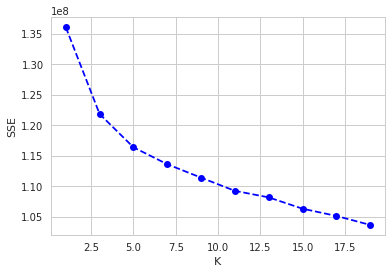

In [172]:
plt.plot(centers, score, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')

In [245]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model=KMeans(14)
pred_demographics=model.fit(pca100_below30).predict(pca100_below30)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

In order to determine the best value for K, I relid on elbow method. It is difficult to find the elbow in the graph so I going with k=14 as of now.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [294]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [295]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#preprocessing
cleaned_customers_less20, cleaned_customers_more20=clean_data(customers)


In [296]:
cleaned_customers_less20.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,4.0,0,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,0.0,2.0,1.0,3.0
2,4.0,1,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,0.0,2.0,3.0,4.0
3,4.0,0,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0,1.0,1.0,2.0,4.0
4,3.0,0,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,1.0,4.0,4.0,1.0
5,3.0,0,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,0.0,2.0,3.0,4.0


In [297]:
#unavailable columns in customer dataframe which are present in the demographic dataframe
set(df_scaled.columns)-set(cleaned_customers_less20.columns)

{'GEBAEUDETYP_5.0'}

In [298]:
#adding the above columns in cleaned_customer_less20 dataframe
cleaned_customers_less20['GEBAEUDETYP_5.0']=0

In [299]:
cleaned_customers_less20.shape

(141640, 196)

In [300]:
#imputation
imputed_customers=impute.transform(cleaned_customers_less20)
imputed_customers=pd.DataFrame(imputed_customers)
imputed_customers.columns=cleaned_customers_less20.columns
imputed_customers.index= cleaned_customers_less20.index

In [301]:
imputed_customers.isnull().sum().sum()

0

In [302]:
#scaling
scaled_customers=scaler.transform(imputed_customers)
scaled_customers=pd.DataFrame(scaled_customers, columns=imputed_customers.columns, index=imputed_customers.index)

In [303]:
#pca
pca_customers=pca100.transform(scaled_customers)

In [306]:
#predictions
pred_customers=model.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [308]:
# Account for rows with many missing values

#for demographic dataframe
df_null_more_20_labels= np.full(df_null_more_20.shape[0],-1)
pred_demographics=np.concatenate([pred_demographics, df_null_more_20_labels])

#for customer dataframe
cleaned_customers_more20_labels=np.full(cleaned_customers_more20.shape[0],-1)
pred_customers=np.concatenate([pred_customers, cleaned_customers_more20_labels])

In [313]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#proportion for demographic data
clusters=list(set(pred_demographics))
pred_demographics=list(pred_demographics)
demographic_ratios=[]
for c in clusters:
    demographic_ratios.append(pred_demographics.count(c)/len(pred_demographics))

In [310]:
#proportion for customer data
clusters=list(set(pred_customers))
pred_customers=list(pred_customers)
customers_ratios=[]
for c in clusters:
    customers_ratios.append(pred_customers.count(c)/len(pred_customers))

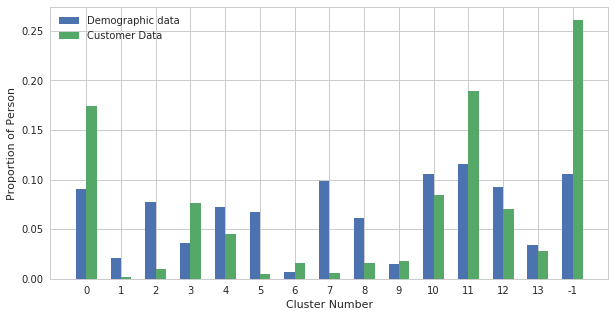

In [312]:
# Numbers of pairs of bars you want
N = 15

# Specify the values of blue bars (height)
blue_bar = demographic_ratios
orange_bar = customers_ratios

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Demographic data')
plt.bar(ind + width, orange_bar, width, label='Customer Data')

plt.xlabel('Cluster Number')
plt.ylabel('Proportion of Person')

plt.xticks(ind + width / 2, clusters)

plt.legend(loc='best')
plt.show()


In [316]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


centroid_12 = scaler.inverse_transform(pca100.inverse_transform(model.cluster_centers_[0]))
overrepresented_c = pd.Series(data = centroid_12, index = cleaned_customers_less20.columns)
overrepresented_c

ALTERSKATEGORIE_GROB               3.275046
ANREDE_KZ                          0.506789
FINANZ_MINIMALIST                  4.527055
FINANZ_SPARER                      1.761169
FINANZ_VORSORGER                   4.077689
FINANZ_ANLEGER                     1.956847
FINANZ_UNAUFFAELLIGER              2.224592
FINANZ_HAUSBAUER                   2.027975
GREEN_AVANTGARDE                   0.995470
HEALTH_TYP                         2.122041
LP_LEBENSPHASE_FEIN               25.130826
LP_LEBENSPHASE_GROB                7.295123
RETOURTYP_BK_S                     3.661087
SEMIO_SOZ                          4.036861
SEMIO_FAM                          3.519346
SEMIO_REL                          3.111375
SEMIO_MAT                          3.216150
SEMIO_VERT                         4.640688
SEMIO_LUST                         5.124185
SEMIO_ERL                          5.130065
SEMIO_KULT                         3.592210
SEMIO_RAT                          3.272366
SEMIO_KRIT                      

**Few Characteristics for over-repsented clusters:**

1. Estimated age around 46 - 60 years old
2. very low financial interest
3. high money-saver
4. be prepared: low



In [317]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_13 = scaler.inverse_transform(pca100.inverse_transform(model.cluster_centers_[7]))
underrepresented_c = pd.Series(data = centroid_13, index = cleaned_customers_less20.columns)
underrepresented_c

ALTERSKATEGORIE_GROB              1.823539
ANREDE_KZ                         0.977621
FINANZ_MINIMALIST                 1.103325
FINANZ_SPARER                     4.451074
FINANZ_VORSORGER                  2.186989
FINANZ_ANLEGER                    4.355612
FINANZ_UNAUFFAELLIGER             3.838525
FINANZ_HAUSBAUER                  4.351139
GREEN_AVANTGARDE                  0.036612
HEALTH_TYP                        2.363279
LP_LEBENSPHASE_FEIN               8.002858
LP_LEBENSPHASE_GROB               2.979234
RETOURTYP_BK_S                    2.623460
SEMIO_SOZ                         3.240578
SEMIO_FAM                         3.920878
SEMIO_REL                         5.308232
SEMIO_MAT                         4.675527
SEMIO_VERT                        2.296974
SEMIO_LUST                        3.324997
SEMIO_ERL                         4.392384
SEMIO_KULT                        4.041086
SEMIO_RAT                         5.905815
SEMIO_KRIT                        5.456101
SEMIO_DOM  

**Few Characteristics for under-repsented clusters**

1. Estimated age around 30-45 years old
2. very high financial interest
3. low money-saver
4. be prepared: high

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

By looking at the combined bar chart, it can be seen that the cluster points like 0, 3, 6 and 11 are highly likely customer segments as there is a higher proportion of persons in a cluster for the customer data compared to the general population. While cluster points like 1,2,4, 5 and 7 are less likely to be turned into customers segments as there is a lower proportion of persons in a cluster for the customer data compared to the general population. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.